# Background

This notebook simulates troubleshooting a machine running a black-box model. A change to the machine has caused the model's calculation time to spike, and various attempts at improving the calculation time need to be evaluated. The only visible part of the model is the logfile that it writes to, and fortunately that logfile includes timestamps for the beginning and end of calculations.  
  
The following code will generate a sample version of the logfile (if it doesn't already exist), parse it into a Pandas DataFrame, and display various analyses of the data, including some visualizations using Matplotlib.

In [1]:
from datetime import datetime, timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from modules.read_logfile import parse_to_dataframe
from modules.create_logfile import dates as dates_of_interventions

In [2]:
data_path = Path('data/logfile')

In [3]:
# If the example logfile does not yet exist, generate it
if not data_path.exists():
    from modules.create_logfile import create_logfile
    if not (parent := data_path.parent).exists():
        parent.mkdir(parents=True)
    create_logfile(data_path)

# Import data

In [4]:
df = parse_to_dataframe(data_path)
df.sample(10)

,start_time,calc_time
451635,2021-01-15 02:39:40.079464,1.952414
1182469,2021-02-06 22:59:52.527954,2.474059
1444,2021-01-01 01:05:32.193049,1.703271
206915,2021-01-07 11:08:44.256800,1.849802
330122,2021-01-11 07:30:39.447418,1.857153
1714317,2021-04-06 23:45:45.616328,11.612345
1271415,2021-02-09 17:40:59.062697,2.727227
1863006,2021-04-24 08:44:48.278966,7.135701
1843216,2021-04-22 06:05:40.943302,7.707443
1348401,2021-02-16 10:10:27.871441,11.546325


# Overview of the Data

In [5]:
print(f"Number of calculations in dataset: {df['start_time'].count()}")
print(f"Average calculation time (s): {df['calc_time'].mean()} ± {df['calc_time'].std()}")
print(f"Start date of dataset: {df['start_time'].min()}")
print(f"End date of dataset: {df['start_time'].max()}")

Number of calculations in dataset: 1972365
Average calculation time (s): 4.975544998653393 ± 4.083818909956866
Start date of dataset: 2021-01-01 00:00:00
End date of dataset: 2021-05-05 23:59:50.568969


# Breakdown by Intervention

In [6]:
# In reality, these were known dates of interventions we performed
# For the purpose of this example, they are being pulled from the dates used to generate the sample logfile
for date in dates_of_interventions:
    print(date)

2021-01-01 00:00:00
2021-02-11 00:00:00
2021-03-05 00:00:00
2021-03-20 00:00:00
2021-04-13 00:00:00
2021-04-22 00:00:00
2021-05-06 00:00:00


Break the data up into periods bounded by dates of various interventions.

In [7]:
periods = {
    'Before interventions': df.loc[df['start_time'] < dates_of_interventions[1]].copy(),
    'After first (bad) intervention': df.loc[df['start_time'].between(dates_of_interventions[1], dates_of_interventions[2])].copy(),
    'After second intervention': df.loc[df['start_time'].between(dates_of_interventions[2], dates_of_interventions[3])].copy(),
    'After third intervention': df.loc[df['start_time'].between(dates_of_interventions[3], dates_of_interventions[4])].copy(),
    'After fourth intervention': df.loc[df['start_time'].between(dates_of_interventions[4], dates_of_interventions[5])].copy(),
    'After fifth intervention': df.loc[df['start_time'] > dates_of_interventions[5]].copy(),
}

Analyze each period and put the analysis into its own dataframe.

In [8]:
names = []
means = []
stds = []
for name, period in periods.items():
    names.append(name)
    means.append(period['calc_time'].mean())
    stds.append(period['calc_time'].std())
    
df_breakdown = pd.DataFrame(data={'intervention_name': names, 'mean': means, 'stdev': stds})
display(df_breakdown)

,intervention_name,mean,stdev
0,Before interventions,2.200113,0.317543
1,After first (bad) intervention,12.300831,1.779125
2,After second intervention,10.999581,1.588035
3,After third intervention,10.503550,1.514417
4,After fourth intervention,9.298696,1.339450
5,After fifth intervention,8.697185,1.254478


# Charting

The data is a bit noisy, so smooth it out with a rolling average

In [9]:
df['rolling_avg'] = df['calc_time'].rolling(500).mean()

Find the closest date in the dataset to the implementation time of each intervention. This will allow for automatic annoation later.

In [10]:
annotations = {
    'First (bad) intervention': min(periods['After first (bad) intervention']['start_time'], key=lambda x: abs(x - dates_of_interventions[1])),
    'Second intervention': min(periods['After second intervention']['start_time'], key=lambda x: abs(x - dates_of_interventions[2])),
    'Third intervention': min(periods['After third intervention']['start_time'], key=lambda x: abs(x - dates_of_interventions[3])),
    'Fourth intervention': min(periods['After fourth intervention']['start_time'], key=lambda x: abs(x - dates_of_interventions[4])),
    'Fifth intervention': min(periods['After fifth intervention']['start_time'], key=lambda x: abs(x - dates_of_interventions[5])),
}

Create a line graph of the data and annotate it with the intervention dates.

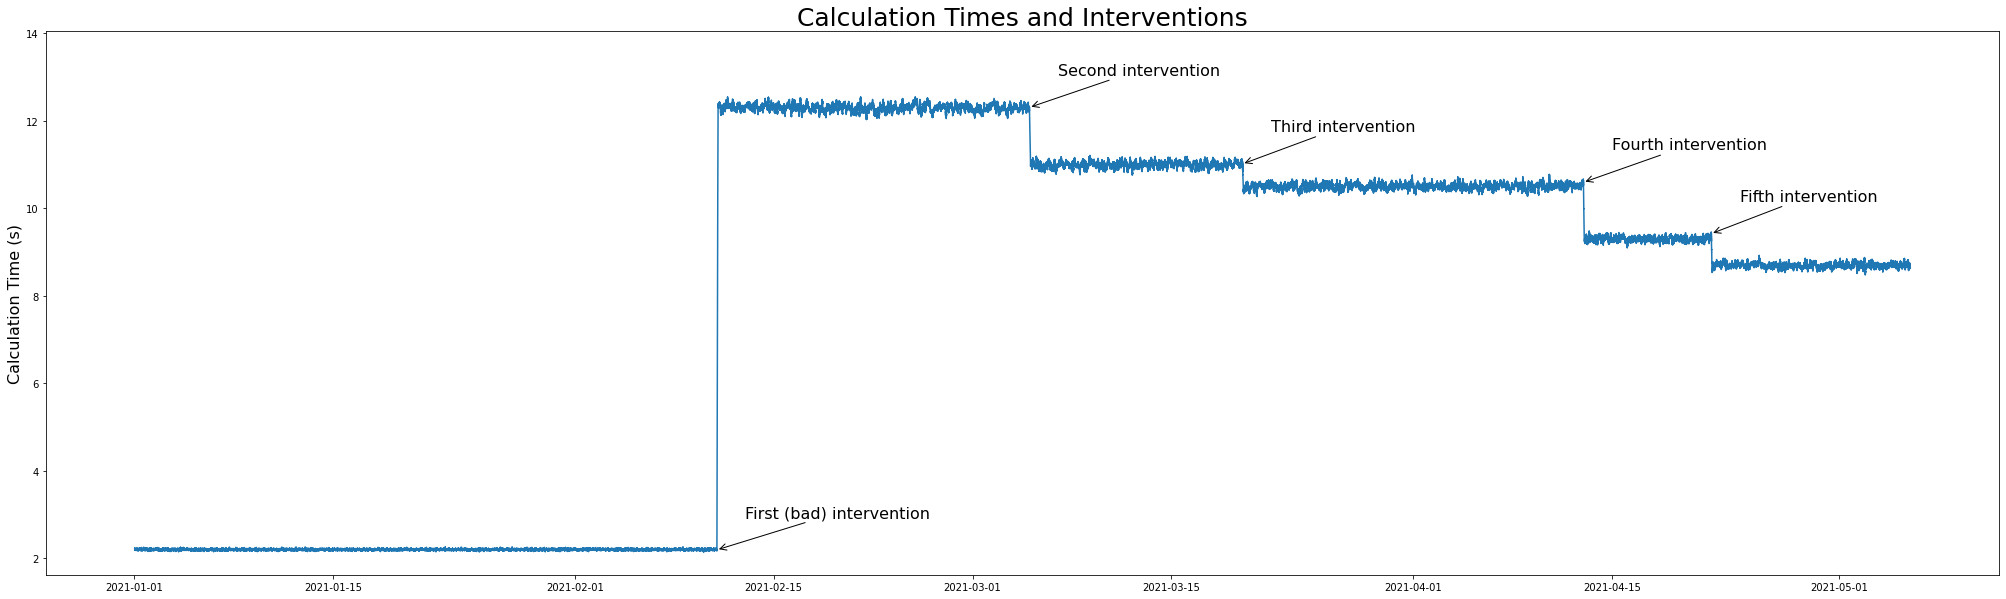

In [11]:
fig, ax = plt.subplots(figsize=(35, 10))

ax.plot(df['start_time'].to_numpy(), df['rolling_avg'].to_numpy())

for annotation, date in annotations.items():
    xy = (date, df.loc[df['start_time'] == date, 'rolling_avg'])
    xytext = (xy[0] + timedelta(days=2), xy[1] + 0.75)
    ax.annotate(annotation, xy, xytext=xytext, arrowprops={'arrowstyle': '->'}, fontsize=16)
    
ax.set_ylim(top=(df['rolling_avg'].max() + 1.5))
    
ax.set_title('Calculation Times and Interventions', fontsize=25)
ax.set_ylabel('Calculation Time (s)', fontsize=16)

plt.show()

Create a bar chart for the intervention periods

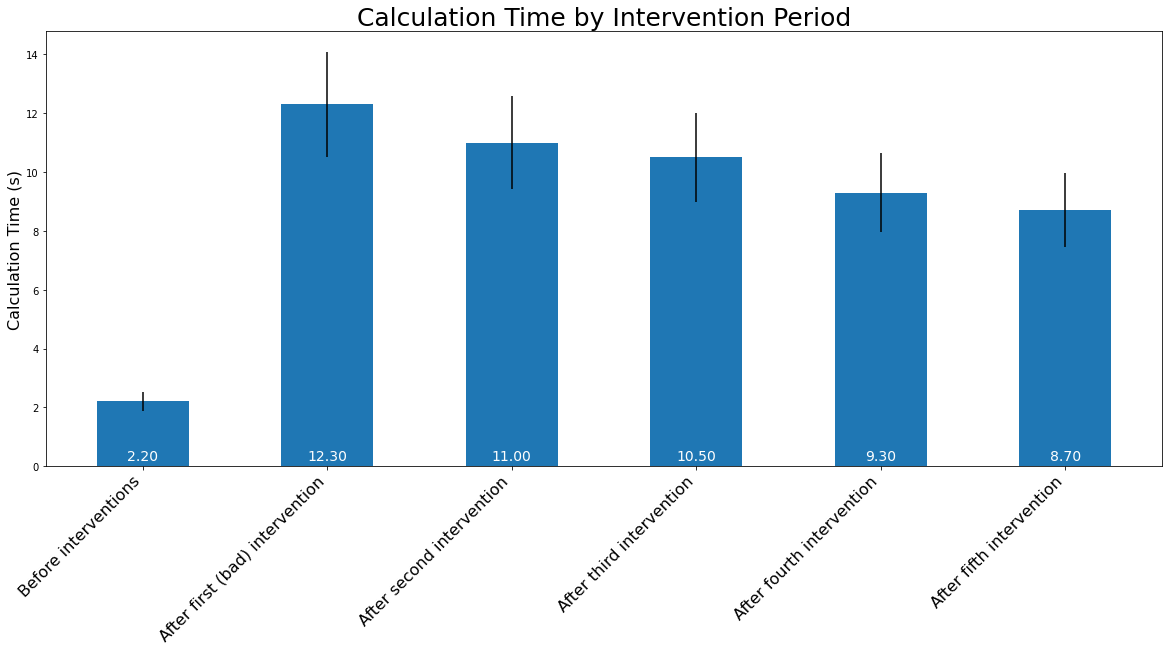

In [12]:
fig, ax = plt.subplots(figsize=(20, 8))

ind = np.arange(len(df_breakdown))
width = 0.5

heights = df_breakdown['mean'].to_numpy()
errors = df_breakdown['stdev'].to_numpy()

rects = ax.bar(ind, height=heights, width=width, yerr=errors)

ax.set_xticks(ind)
ax.set_xticklabels((df_breakdown['intervention_name']), rotation=45, horizontalalignment='right', fontsize=16)

ax.set_title('Calculation Time by Intervention Period', fontsize=25)
ax.set_ylabel('Calculation Time (s)', fontsize=16)

for rect in rects:
    ax.annotate(f'{rect.get_height():0.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, 0),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=14,
                color='white')

plt.show()